## Data Description

- Item_Identifier: Unique product ID

- Item_Weight: Weight of product

- Item_Fat_Content: Whether the product is low fat or not

- Item_Visibility: The % of total display area of all products in a store allocated to the particular product

- Item_Type: The category to which the product belongs

- Item_MRP: Maximum Retail Price (list price) of the product

- Outlet_Identifier: Unique store ID

- Outlet_Establishment_Year: The year in which store was established

- Outlet_Size: The size of the store in terms of ground area covered

- Outlet_Location_Type: The type of city in which the store is located

- Outlet_Type: Whether the outlet is just a grocery store or some sort of supermarket

- Item_Outlet_Sales: Sales of the product in the particulat store. This is the outcome variable to be predicted.

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re

In [2]:
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
train_df = pd.read_csv("train.csv")

In [6]:
train_df.shape

(8523, 12)

In [7]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [8]:
test_df = pd.read_csv("test.csv")

In [9]:
test_df.shape

(5681, 11)

In [10]:
test_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [11]:
#Checking the memory usage of both dataframes

print("Train set: {:2.2f} Mb".format(train_df.memory_usage().sum() / 1024**2))
print("Test set: {:2.2f} Mb".format(test_df.memory_usage().sum() / 1024**2))

Train set: 0.78 Mb
Test set: 0.48 Mb


These dataframes are small and their memory usage does not have to be reduced.

## Handling Missing Values

In [12]:
train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


Only the Item_Weight and Outlet_Size columns have missing values. Let's check if they can be derived from the other columns.

In [14]:
#Creating a boolean series with True for every null value in the Item_Weight column
bool_ItemWeight = pd.isnull(train_df['Item_Weight'])

#Viewing the Item_Identifier and Item_Weight columns where the Item_Weight is null
train_df[['Item_Identifier', 'Item_Weight']][bool_ItemWeight]

,Item_Identifier,Item_Weight
7,FDP10,NaN
18,DRI11,NaN
21,FDW12,NaN
23,FDC37,NaN
29,FDC14,NaN
...,...,...
8485,DRK37,NaN
8487,DRG13,NaN
8488,NCN14,NaN
8490,FDU44,NaN


In [15]:
#Grouping the train dataframe by the Item_Identifier column
item_groupby = train_df.groupby(['Item_Identifier'])

In [16]:
#Checking the Item_Weight values for the Item_Identifier value 'DRI11'
item_groupby.get_group('DRI11')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
1366,DRI11,NaN,Low Fat,0.060237,Hard Drinks,115.9834,OUT019,1985,Small,Tier 1,Grocery Store,345.5502
3127,DRI11,8.26,Low Fat,0.034458,Hard Drinks,113.3834,OUT049,1999,Medium,Tier 1,Supermarket Type1,2073.3012
5310,DRI11,8.26,Low Fat,0.057586,Hard Drinks,113.7834,OUT010,1998,NaN,Tier 3,Grocery Store,115.1834
7022,DRI11,8.26,Low Fat,0.034398,Hard Drinks,115.7834,OUT035,2004,Small,Tier 2,Supermarket Type1,2073.3012
7192,DRI11,8.26,Low Fat,0.034544,Hard Drinks,116.0834,OUT018,2009,Medium,Tier 3,Supermarket Type2,1267.0174
8483,DRI11,8.26,Low Fat,0.034474,Hard Drinks,117.0834,OUT045,2002,NaN,Tier 2,Supermarket Type1,1612.5676


As expected, we can get item weights from the item identifier column. But we need to check that the item weight is constant for a given item before imputing them in the null values.

In [17]:
#Checking the number of unique item types
train_df['Item_Identifier'].describe()

count      8523
unique     1559
top       FDW13
freq         10
Name: Item_Identifier, dtype: object

Since the number of unique items is very high, it's not possible to manually check item weights for each item. Let's create a mapping of item identifiers and item weights.

In [18]:
#Creating a list of items that have atleast one null value in the item weight column
null_items_list = list(set(train_df['Item_Identifier'][bool_ItemWeight]))
len(null_items_list)

1142

Next, identifying the rows that don't have null values, so that their item weights can be checked.

In [19]:
#Creating a boolean series with True for every non-null value in the Item_Weight column
bool_ItemWeight_notnull = pd.notnull(train_df['Item_Weight'])

In [20]:
#This piece of code displays the values in column 'Item_Weight' for the specified values in column 'Item_Identifier'
train_df[bool_ItemWeight_notnull].loc[train_df['Item_Identifier']=='FDP10', 'Item_Weight']

585     19.0
2623    19.0
3382    19.0
4585    19.0
6087    19.0
7883    19.0
Name: Item_Weight, dtype: float64

In [21]:
#Checking that the item weight is the same for all values of the specified item
len(set(train_df[bool_ItemWeight_notnull].loc[train_df['Item_Identifier']=='FDP10', 'Item_Weight']))

1

In [22]:
train_df_backup = train_df.copy()
test_df_backup = test_df.copy()
print("Train shape: ", train_df_backup.shape)
print("Test shape: ", test_df_backup.shape)

Train shape:  (8523, 12)
Test shape:  (5681, 11)


In [23]:
#Looping through the list of items that have atleast one row with missing weight
for i in null_items_list:
    check_weights = len(set(train_df[bool_ItemWeight_notnull].loc[train_df['Item_Identifier']==i, 'Item_Weight']))
    
    #Checking if the available item weights are the same for the item in this loop
    if check_weights==1:
        
        #Getting the item weight
        item_weight = list(set(train_df[bool_ItemWeight_notnull].loc[train_df['Item_Identifier']==i, 'Item_Weight']))
        
        #Imputing this weight in the train and test sets
        train_df.loc[train_df['Item_Identifier']==i, 'Item_Weight'] = item_weight[0]
        test_df.loc[test_df['Item_Identifier']==i, 'Item_Weight'] = item_weight[0]

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8519 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                5132 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


Let's check the rows that still have null values in the Item_Weight column.

In [26]:
#Checking for null values in the Item_Weight column
bool_ItemWeight_new = pd.isnull(train_df['Item_Weight'])

#Viewing the identifier and weight columns where Item_Weight is null
train_df[['Item_Identifier', 'Item_Weight']][bool_ItemWeight_new]

,Item_Identifier,Item_Weight
927,FDN52,NaN
1922,FDK57,NaN
4187,FDE52,NaN
5022,FDQ60,NaN


In [27]:
#Viewing the rows with the specified item identifier
print("FDN52: ",train_df.loc[train_df['Item_Identifier']=='FDN52', 'Item_Weight'])
print("FDK57: ",train_df.loc[train_df['Item_Identifier']=='FDK57', 'Item_Weight'])
print("FDE52: ",train_df.loc[train_df['Item_Identifier']=='FDE52', 'Item_Weight'])
print("FDQ60: ",train_df.loc[train_df['Item_Identifier']=='FDQ60', 'Item_Weight'])

FDN52:  927   NaN
Name: Item_Weight, dtype: float64
FDK57:  1922   NaN
Name: Item_Weight, dtype: float64
FDE52:  4187   NaN
Name: Item_Weight, dtype: float64
FDQ60:  5022   NaN
Name: Item_Weight, dtype: float64


The weight of these items is not present in the train set. Checking if they are present in the test set.

In [28]:
#Viewing the rows with the specified item identifier
print("FDN52: ",test_df.loc[test_df['Item_Identifier']=='FDN52', 'Item_Weight'])
print("FDK57: ",test_df.loc[test_df['Item_Identifier']=='FDK57', 'Item_Weight'])
print("FDE52: ",test_df.loc[test_df['Item_Identifier']=='FDE52', 'Item_Weight'])
print("FDQ60: ",test_df.loc[test_df['Item_Identifier']=='FDQ60', 'Item_Weight'])

FDN52:  396     9.395
1547    9.395
2963    9.395
3070    9.395
3171    9.395
3579    9.395
4252    9.395
5271    9.395
Name: Item_Weight, dtype: float64
FDK57:  1163    10.195
1501    10.195
1576    10.195
1793    10.195
2438    10.195
4297    10.195
4806    10.195
4942    10.195
Name: Item_Weight, dtype: float64
FDE52:  59      10.395
144     10.395
502     10.395
1081    10.395
1980    10.395
5196    10.395
5221    10.395
Name: Item_Weight, dtype: float64
FDQ60:  440     6.195
1059    6.195
1713    6.195
1724      NaN
2044    6.195
4154    6.195
4524    6.195
5535    6.195
Name: Item_Weight, dtype: float64


These weights (from the test set) can be imputed in the train set.

In [29]:
weights_in_test = ['FDN52', 'FDK57', 'FDE52', 'FDQ60']

#Finding the rows where the weight is not null in the test set
bool_IW_notnull_test = pd.notnull(test_df['Item_Weight'])

#Looping through this list
for i in weights_in_test:
        
    #Getting the number of unique weight values for this item
    check_weights = len(set(test_df[bool_IW_notnull_test].loc[test_df['Item_Identifier']==i, 'Item_Weight']))
    
    #Checking if the available item weights are the same for the item
    if check_weights==1:
        
        #Getting the item weight
        item_weight = list(set(test_df[bool_IW_notnull_test].loc[test_df['Item_Identifier']==i, 'Item_Weight']))
        
        #Imputing this weight in the train and test sets
        train_df.loc[train_df['Item_Identifier']==i, 'Item_Weight'] = item_weight[0]
        test_df.loc[test_df['Item_Identifier']==i, 'Item_Weight'] = item_weight[0]

In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [31]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                5133 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


The missing values in the Item_Weight in the train set have been imputed. Let's check for the missing values in the same column in the test set.

In [32]:
#Checking for null values in the Item_Weight column in the test set
bool_IW_isnull_test = pd.isnull(test_df['Item_Weight'])

#Viewing the identifier and weight columns where Item_Weight is null in the test set
test_df[['Item_Identifier', 'Item_Weight']][bool_IW_isnull_test]

,Item_Identifier,Item_Weight
12,NCC54,NaN
18,NCM42,NaN
23,NCL19,NaN
30,NCR42,NaN
33,FDU31,NaN
...,...,...
5634,NCV42,NaN
5640,FDI60,NaN
5656,FDC39,NaN
5665,DRE03,NaN


Let's check if these items are present in the train set.

In [33]:
#Creating a list of items that have atleast one null value in the item weight column
null_items_list_test = list(set(test_df['Item_Identifier'][bool_IW_isnull_test]))
len(null_items_list_test)

417

In [34]:
#Checking for null values in the Item_Weight column in the test set
bool_IW_notnull_train = pd.notnull(train_df['Item_Weight'])

#Looping through the list of items that have atleast one row with missing weight in the test set

for i in null_items_list_test:
    check_weights = len(set(train_df[bool_IW_notnull_train].loc[train_df['Item_Identifier']==i, 'Item_Weight']))
    
    #Checking if the available item weights are the same for the item in this loop
    if check_weights==1:
        
        #Getting the item weight
        item_weight = list(set(train_df[bool_IW_notnull_train].loc[train_df['Item_Identifier']==i, 'Item_Weight']))
        
        #Imputing this weight in the test set
        test_df.loc[test_df['Item_Identifier']==i, 'Item_Weight'] = item_weight[0]

In [35]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                5681 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


The missing values in the test set have been imputed from the train set. Next, checking the Outlet_Size column in the train set.

In [36]:
#Checking for non-null values in the Outlet_Size column
bool_OS_notnull = pd.notnull(train_df['Outlet_Size'])

#Viewing the outlet size and outlet type columns where Outlet_Size is null
train_df[['Outlet_Size', 'Outlet_Type', 'Outlet_Identifier']][bool_OS_notnull]

,Outlet_Size,Outlet_Type,Outlet_Identifier
0,Medium,Supermarket Type1,OUT049
1,Medium,Supermarket Type2,OUT018
2,Medium,Supermarket Type1,OUT049
4,High,Supermarket Type1,OUT013
5,Medium,Supermarket Type2,OUT018
...,...,...,...
8517,Small,Supermarket Type1,OUT046
8518,High,Supermarket Type1,OUT013
8520,Small,Supermarket Type1,OUT035
8521,Medium,Supermarket Type2,OUT018


It looks like Outlet_Size can be obtained from Outlet_Identifier.

In [37]:
#Checking the number of outlets
train_df['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT035    930
OUT049    930
OUT046    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

In [38]:
#Checking the number of outlets in the test set
test_df['Outlet_Identifier'].value_counts()

OUT027    624
OUT013    621
OUT035    620
OUT049    620
OUT046    620
OUT045    619
OUT018    618
OUT017    617
OUT010    370
OUT019    352
Name: Outlet_Identifier, dtype: int64

The same outlets are present in both train and test sets.

In [39]:
#Creating a list of outlet identifiers

outlet_identifiers_list = list(set(train_df['Outlet_Identifier']))
len(outlet_identifiers_list)

10

In [40]:
#Checking if there is at least one valid entry in the Outlet_Size column for each outlet
for i in outlet_identifiers_list:
    print("Outlet: ", i)
    print("Outlet Size: ", train_df[bool_OS_notnull].loc[train_df['Outlet_Identifier']==i, 'Outlet_Size'])
    print("\n")

Outlet:  OUT019
Outlet Size:  23      Small
29      Small
49      Small
59      Small
63      Small
        ...  
8454    Small
8458    Small
8469    Small
8480    Small
8490    Small
Name: Outlet_Size, Length: 528, dtype: object


Outlet:  OUT018
Outlet Size:  1       Medium
5       Medium
16      Medium
31      Medium
32      Medium
         ...  
8506    Medium
8511    Medium
8515    Medium
8516    Medium
8521    Medium
Name: Outlet_Size, Length: 928, dtype: object


Outlet:  OUT013
Outlet Size:  4       High
6       High
14      High
20      High
27      High
        ... 
8462    High
8466    High
8484    High
8512    High
8518    High
Name: Outlet_Size, Length: 932, dtype: object


Outlet:  OUT010
Outlet Size:  Series([], Name: Outlet_Size, dtype: object)


Outlet:  OUT027
Outlet Size:  7       Medium
18      Medium
21      Medium
36      Medium
38      Medium
         ...  
8472    Medium
8485    Medium
8487    Medium
8488    Medium
8504    Medium
Name: Outlet_Size, Length: 935, 

The outlet size is not available for the following outlets in the train set: OUT010, OUT045, and OUT017. Let's check if they are available in the test set.

In [41]:
#Checking if there is at least one valid entry in the Outlet_Size column for each outlet in the test set

bool_OS_notnull_test = pd.notnull(test_df['Outlet_Size'])

for i in outlet_identifiers_list:
    print("Outlet: ", i)
    print("Outlet Size: ", test_df[bool_OS_notnull_test].loc[test_df['Outlet_Identifier']==i, 'Outlet_Size'])
    print("\n")

Outlet:  OUT019
Outlet Size:  12      Small
23      Small
30      Small
58      Small
76      Small
        ...  
5546    Small
5583    Small
5596    Small
5600    Small
5643    Small
Name: Outlet_Size, Length: 352, dtype: object


Outlet:  OUT018
Outlet Size:  6       Medium
17      Medium
31      Medium
32      Medium
40      Medium
         ...  
5636    Medium
5663    Medium
5664    Medium
5673    Medium
5677    Medium
Name: Outlet_Size, Length: 618, dtype: object


Outlet:  OUT013
Outlet Size:  14      High
20      High
45      High
51      High
56      High
        ... 
5633    High
5651    High
5654    High
5658    High
5660    High
Name: Outlet_Size, Length: 621, dtype: object


Outlet:  OUT010
Outlet Size:  Series([], Name: Outlet_Size, dtype: object)


Outlet:  OUT027
Outlet Size:  4       Medium
7       Medium
18      Medium
33      Medium
35      Medium
         ...  
5655    Medium
5656    Medium
5661    Medium
5665    Medium
5669    Medium
Name: Outlet_Size, Length: 624, 

The outlet size is missing in the test set for the same outlets. The outlet size cannot be imputed from the test size. Therefore, I'll impute the mode outlet size for each outlet type.

In [42]:
#Grouping by outlet type
grouped_df = train_df[['Outlet_Type', 'Outlet_Size']].groupby('Outlet_Type')

In [43]:
#Checking the outlet size mode for each outlet type
for key, item in grouped_df:
    print("Key: ", key)
    print(grouped_df.get_group(key).mode(), "\n\n")

Key:  Grocery Store
     Outlet_Type Outlet_Size
0  Grocery Store       Small 


Key:  Supermarket Type1
         Outlet_Type Outlet_Size
0  Supermarket Type1       Small 


Key:  Supermarket Type2
         Outlet_Type Outlet_Size
0  Supermarket Type2      Medium 


Key:  Supermarket Type3
         Outlet_Type Outlet_Size
0  Supermarket Type3      Medium 




In [44]:
#Checking the number of medium, small, high, and null values in the outlet size column (in both train and test sets)
print("Train set\n" )
print(train_df['Outlet_Size'].value_counts(), "\n")
print("Number of null values in train set: ", len(train_df[train_df['Outlet_Size'].isnull()]))
print("\n\nTest set\n" )
print(test_df['Outlet_Size'].value_counts(), "\n")
print("Number of null values in test set: ", len(test_df[test_df['Outlet_Size'].isnull()]))

Train set

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64 

Number of null values in train set:  2410


Test set

Medium    1862
Small     1592
High       621
Name: Outlet_Size, dtype: int64 

Number of null values in test set:  1606


Since small and medium outlet sizes are the modes for some outlet types, and high outlet size is not the mode for any outlet type, the value counts should increase only for these two outlet types (after imputation).

In [45]:
#Creating a list of outlet types
outlet_type_list = list(train_df['Outlet_Type'].unique())
outlet_type_list

['Supermarket Type1',
 'Supermarket Type2',
 'Grocery Store',
 'Supermarket Type3']

In [46]:
#Looping through the list of outlet types to impute the mode outlet size for that type
for i in outlet_type_list:
    
    if ((i == 'Grocery Store') | (i == 'Supermarket Type1')):
        train_df.loc[(train_df['Outlet_Type']==i) & (pd.isnull(train_df['Outlet_Size'])), 'Outlet_Size'] = 'Small'
        test_df.loc[(test_df['Outlet_Type']==i) & (pd.isnull(test_df['Outlet_Size'])), 'Outlet_Size'] = 'Small'
    
    else:
        train_df.loc[(train_df['Outlet_Type']==i) & (pd.isnull(train_df['Outlet_Size'])), 'Outlet_Size'] = 'Medium'
        test_df.loc[(test_df['Outlet_Type']==i) & (pd.isnull(test_df['Outlet_Size'])), 'Outlet_Size'] = 'Medium'


In [47]:
#Checking the same numbers after imputation
print("Train set\n" )
print(train_df['Outlet_Size'].value_counts(), "\n")
print("Number of null values in train set: ", len(train_df[train_df['Outlet_Size'].isnull()]))
print("\n\nTest set\n" )
print(test_df['Outlet_Size'].value_counts(), "\n")
print("Number of null values in test set: ", len(test_df[test_df['Outlet_Size'].isnull()]))

Train set

Small     4798
Medium    2793
High       932
Name: Outlet_Size, dtype: int64 

Number of null values in train set:  0


Test set

Small     3198
Medium    1862
High       621
Name: Outlet_Size, dtype: int64 

Number of null values in test set:  0


As expected, only the small and medium value counts have gone up.

In [48]:
#Checking if there are any null values
print(train_df.info(), "\n\n")
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None 


<class 'pandas.core.frame.DataFrame'>

#### Deleting the existing variables that are not necessary

In [49]:
%who

DecisionTreeRegressor	 FeatureHasher	 GridSearchCV	 KFold	 LinearRegression	 OneHotEncoder	 RandomForestRegressor	 StandardScaler	 bool_IW_isnull_test	 
bool_IW_notnull_test	 bool_IW_notnull_train	 bool_ItemWeight	 bool_ItemWeight_new	 bool_ItemWeight_notnull	 bool_OS_notnull	 bool_OS_notnull_test	 check_weights	 cross_val_score	 
gc	 grouped_df	 i	 item	 item_groupby	 item_weight	 key	 mean_squared_error	 mode	 
np	 null_items_list	 null_items_list_test	 outlet_identifiers_list	 outlet_type_list	 pd	 plt	 r2_score	 re	 
sns	 test_df	 test_df_backup	 time	 train_df	 train_df_backup	 train_test_split	 warnings	 weights_in_test	 



In [50]:
del (bool_IW_isnull_test, bool_IW_notnull_test, bool_IW_notnull_train, bool_ItemWeight, bool_ItemWeight_new, 
     bool_ItemWeight_notnull, bool_OS_notnull, bool_OS_notnull_test, check_weights, null_items_list, 
     null_items_list_test, outlet_identifiers_list, outlet_type_list, test_df_backup, train_df_backup)

In [51]:
#Triggering garbage collection

gc.collect()

160

In [52]:
#Creating a backup of the train and test sets
train_df_backup = train_df.copy()
test_df_backup = test_df.copy()

## Data Exploration and Visualization

In [53]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


I'll go through the categorical columns first.

#### Item_Identifier

In [54]:
#Checking the number of categories in the item identifier column
len(train_df['Item_Identifier'].unique())

1559

This is far too many categories. Let's check if there is a higher category level that we can use to reduce the number of categories.

In [55]:
train_df.head(50)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,19.000,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,Small,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,Small,Tier 2,Supermarket Type1,4710.5350


Let's check the number of categories if the first three characters of this column are used.

In [56]:
first_three = train_df['Item_Identifier'].apply(lambda x: re.match('^.{3}', x).group())
print(first_three[0:10])
print("Number of categories: ", len(first_three.unique()))

0    FDA
1    DRC
2    FDN
3    FDX
4    NCD
5    FDP
6    FDO
7    FDP
8    FDH
9    FDU
Name: Item_Identifier, dtype: object
Number of categories:  71


71 is still too many categories. Let's check the number of categories if the first two characters are used.

In [57]:
first_two = train_df['Item_Identifier'].apply(lambda x: re.match('^.{2}', x).group())
print(first_two[0:10])
print("Number of categories: ", len(first_two.unique()))

0    FD
1    DR
2    FD
3    FD
4    NC
5    FD
6    FD
7    FD
8    FD
9    FD
Name: Item_Identifier, dtype: object
Number of categories:  3


It looks like the items can broadly be divided into three categories:
- FD -- Food
- NC -- Non-Consumable
- DR -- Drinks

I'll replace each item identifier with the first two characters.

In [58]:
#Retaining only the first two characters in the item identifier column
train_df['Item_Identifier'] = train_df['Item_Identifier'].apply(lambda x: re.match('^.{2}', x).group())
test_df['Item_Identifier'] = test_df['Item_Identifier'].apply(lambda x: re.match('^.{2}', x).group())

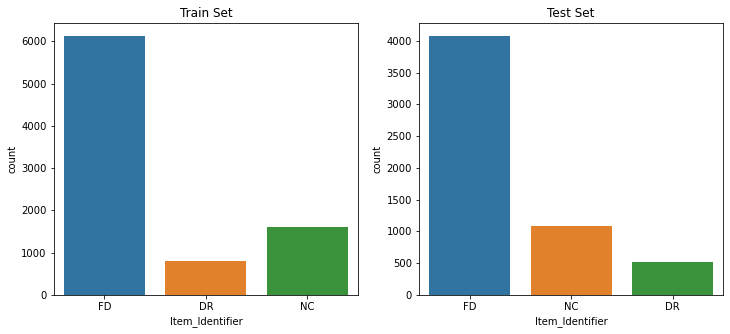

In [59]:
#Plotting the number of items that belong to these three categories

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Item_Identifier'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Item_Identifier'])

plt.show()

#### Item_Fat_Content

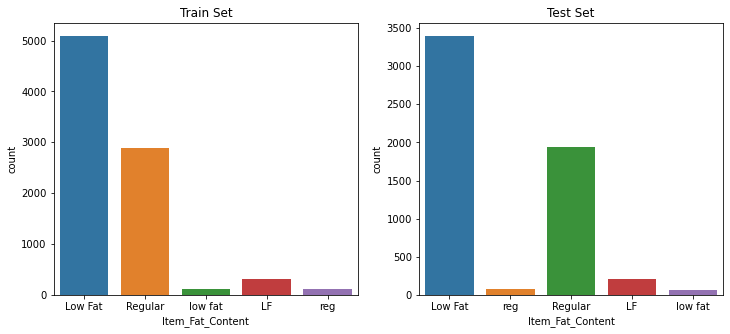

In [60]:
#Plotting the number of items in the Item_Fat_Content column

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Item_Fat_Content'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Item_Fat_Content'])

plt.show()

It looks like 'LF' and 'low fat' are the same as the category 'Low Fat'. The same applies to 'reg' and 'Regular'.

In [61]:
#Substituting 'Low Fat' inplace of 'low fat' and 'LF'

train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: re.sub('low fat', 'Low Fat', x))
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: re.sub('LF', 'Low Fat', x))

test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: re.sub('low fat', 'Low Fat', x))
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: re.sub('LF', 'Low Fat', x))


#Substituting 'Regular' inplace of 'reg'

train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: re.sub('reg', 'Regular', x))
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: re.sub('reg', 'Regular', x))

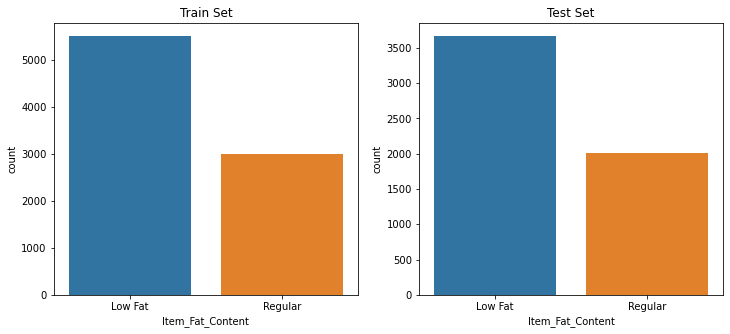

In [62]:
#Checking the Item_Fat_Content column again

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Item_Fat_Content'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Item_Fat_Content'])

plt.show()

#### Item_Type

In [63]:
print(train_df['Item_Type'].unique(), "\n")
print("Number of item types: ", len(train_df['Item_Type'].unique()))

['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood'] 

Number of item types:  16


#### Outlet_Identifier

In [64]:
print(train_df['Outlet_Identifier'].unique(), "\n")
print("Number of outlets: ", len(train_df['Outlet_Identifier'].unique()))

['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019'] 

Number of outlets:  10


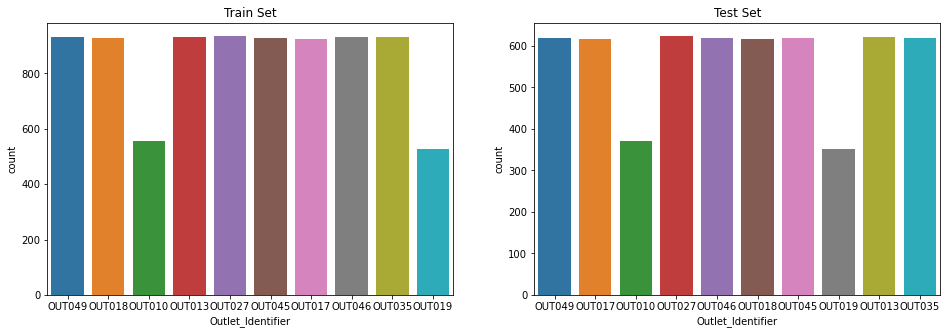

In [65]:
#Checking the Outlet_Identifier column

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Identifier'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Identifier'])

plt.show()

#### Outlet_Establishment_Year

In [66]:
print(train_df['Outlet_Establishment_Year'].unique(), "\n")
print("Number of outlets: ", len(train_df['Outlet_Establishment_Year'].unique()))

[1999 2009 1998 1987 1985 2002 2007 1997 2004] 

Number of outlets:  9


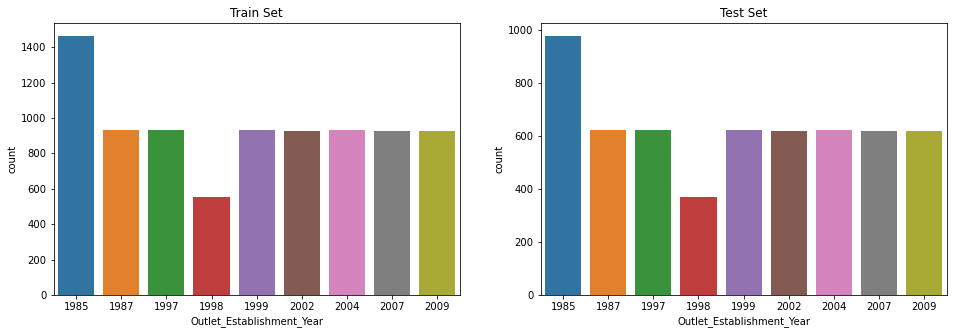

In [67]:
#Checking the Outlet_Establishment_Year column

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Establishment_Year'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Establishment_Year'])

plt.show()

Since the year of establishing an outlet cannot be used directly in a model, I'll convert these years into age of the outlet.

In [68]:
#I'll consider the age of the outlet in the year 2010
train_df['Outlet_Establishment_Year'] = 2010 - train_df['Outlet_Establishment_Year']
test_df['Outlet_Establishment_Year'] = 2010 - test_df['Outlet_Establishment_Year']

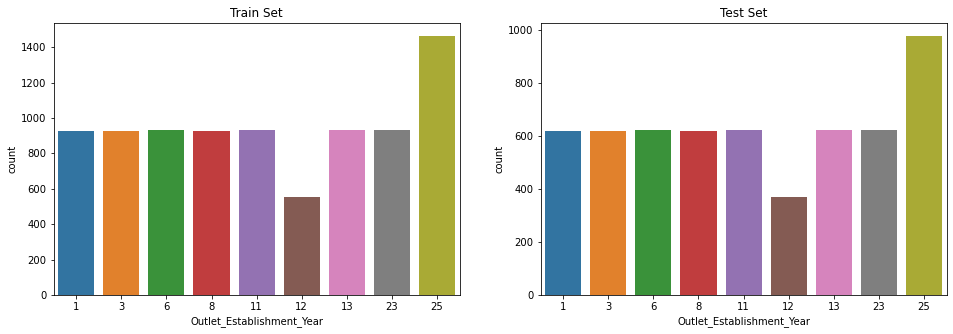

In [69]:
#Checking the Outlet_Establishment_Year column again

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Establishment_Year'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Establishment_Year'])

plt.show()

As we can see from these graphs, most outlets were established in 1985 and are 25 years old in the year 2010.

#### Outlet_Size

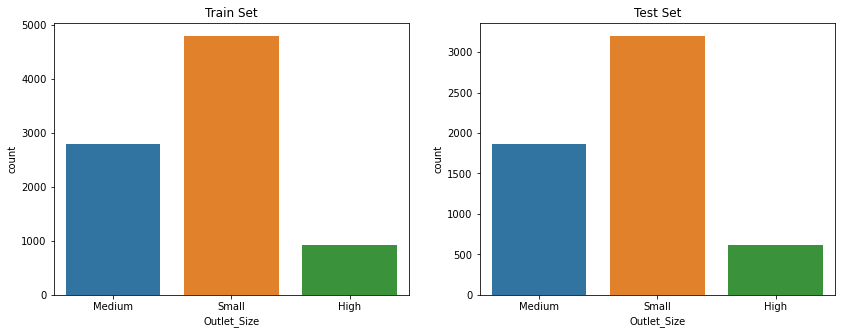

In [70]:
#Checking the Outlet_Size column

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Size'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Size'])

plt.show()

#### Outlet_Location_Type

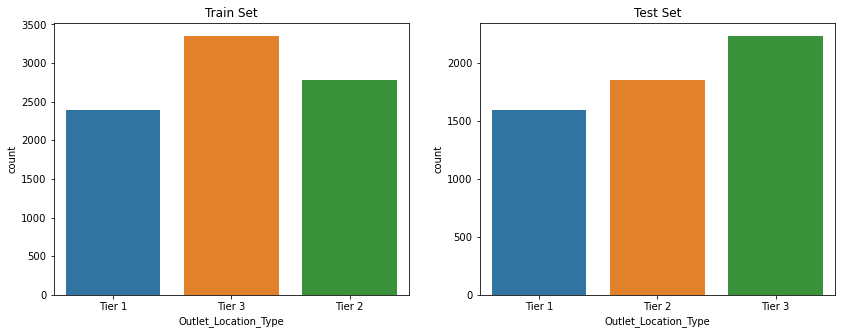

In [71]:
#Checking the Outlet_Location_Type column

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Location_Type'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Location_Type'])

plt.show()

#### Outlet_Type

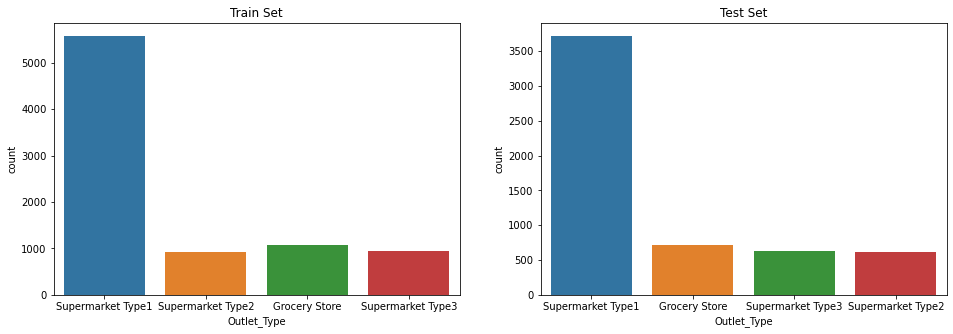

In [72]:
#Checking the Outlet_Type column

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.title("Train Set")
sns.countplot(train_df['Outlet_Type'])

plt.subplot(1, 2, 2)
plt.title("Test Set")
sns.countplot(test_df['Outlet_Type'])

plt.show()

#### Continous Variables

In [73]:
#Checking the spread of continous variables
train_df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.873623,0.066132,140.992782,12.168133
std,4.645893,0.051598,62.275067,8.371760
min,4.555000,0.000000,31.290000,1.000000
25%,8.785000,0.026989,93.826500,6.000000
50%,12.600000,0.053931,143.012800,11.000000
75%,16.850000,0.094585,185.643700,23.000000
max,21.350000,0.328391,266.888400,25.000000


There don't appear to be any outliers. The minimum value in the Item_Visibility column is zero. If the item is on display in the outlet, the visibility percentage should not be zero. I'll check if Item_Outlet_Sales = 0 when Item_Visibility = 0, as this would indicate that the item is not on the shelves of the outlet.

In [74]:
#Checking if an item is not on the shelves of an outlet when the visibility is zero
train_df[(train_df['Item_Visibility']==0) & (train_df['Item_Outlet_Sales']==0)]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


It looks like the item is present on the shelf, as it has a corresponding sales figure.

In [75]:
#Checking if the item visibility is zero only in a particular outlet

print("Number of outlets: ", len(train_df['Outlet_Identifier'].unique()))
print("Number of outlets with item visibility zero for an item: ", 
      len(train_df['Outlet_Identifier'][train_df['Item_Visibility']==0].unique()))

Number of outlets:  10
Number of outlets with item visibility zero for an item:  10


In [76]:
#Checking if the item visibility is zero only for a particular item

print("Number of items: ", len(train_df['Item_Type'].unique()))
print("Number of items with item visibility zero: ", 
      len(train_df['Item_Type'][train_df['Item_Visibility']==0].unique()))

Number of items:  16
Number of items with item visibility zero:  16


It looks like all items have zero visibility in one outlet or another. Similarly, all outlets have at least one item with zero visibility. This is unlikely to be a data entry error and more likely to be a result of rounding values lower than a threshold value to zero.

In [77]:
#Checking for the lowest non-zero values in the Item_Visibility column
print("Number of rows where 0 < Item_Visibility < 0.01: ", train_df[(train_df['Item_Visibility'] < 0.01) & (train_df['Item_Visibility'] > 0)].shape[0])
print("Number of rows where 0 < Item_Visibility < 0.001: ", train_df[(train_df['Item_Visibility'] < 0.001) & (train_df['Item_Visibility'] > 0)].shape[0])

Number of rows where 0 < Item_Visibility < 0.01:  206
Number of rows where 0 < Item_Visibility < 0.001:  0


It looks like values lower than 0.001 have been rounded to zero in this column. I'll add 0.001 to all values of this column, as Item_Visibility is a percentage and 0.001 = 0.1%

In [78]:
#Checking if the test set also has zero values in the Item_Visibility column
test_df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,5681.000000,5681.000000,5681.000000,5681.000000
mean,12.672996,0.065684,141.023273,12.171097
std,4.658256,0.051252,61.809091,8.372256
min,4.555000,0.000000,31.990000,1.000000
25%,8.615000,0.027047,94.412000,6.000000
50%,12.350000,0.054154,141.415400,11.000000
75%,16.700000,0.093463,186.026600,23.000000
max,21.350000,0.323637,266.588400,25.000000


Adding 0.001 to all Item_Visibility values.

In [79]:
train_df['Item_Visibility'] = train_df['Item_Visibility'] + 0.001
test_df['Item_Visibility'] = test_df['Item_Visibility'] + 0.001

#### Item_Outlet_Sales

In [80]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FD,9.30,Low Fat,0.017047,Dairy,249.8092,OUT049,11,Medium,Tier 1,Supermarket Type1,3735.1380
1,DR,5.92,Regular,0.020278,Soft Drinks,48.2692,OUT018,1,Medium,Tier 3,Supermarket Type2,443.4228
2,FD,17.50,Low Fat,0.017760,Meat,141.6180,OUT049,11,Medium,Tier 1,Supermarket Type1,2097.2700
3,FD,19.20,Regular,0.001000,Fruits and Vegetables,182.0950,OUT010,12,Small,Tier 3,Grocery Store,732.3800
4,NC,8.93,Low Fat,0.001000,Household,53.8614,OUT013,23,High,Tier 3,Supermarket Type1,994.7052


<AxesSubplot:xlabel='Item_Outlet_Sales', ylabel='Density'>

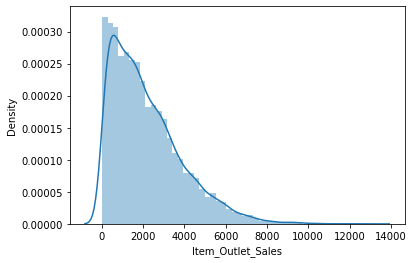

In [81]:
sns.distplot(train_df['Item_Outlet_Sales'])

This is not close to a normal distribution. I'll try transforming the variable and plotting their graphs to see the transformed distribution.

## Data Preparation

In [82]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import yeojohnson

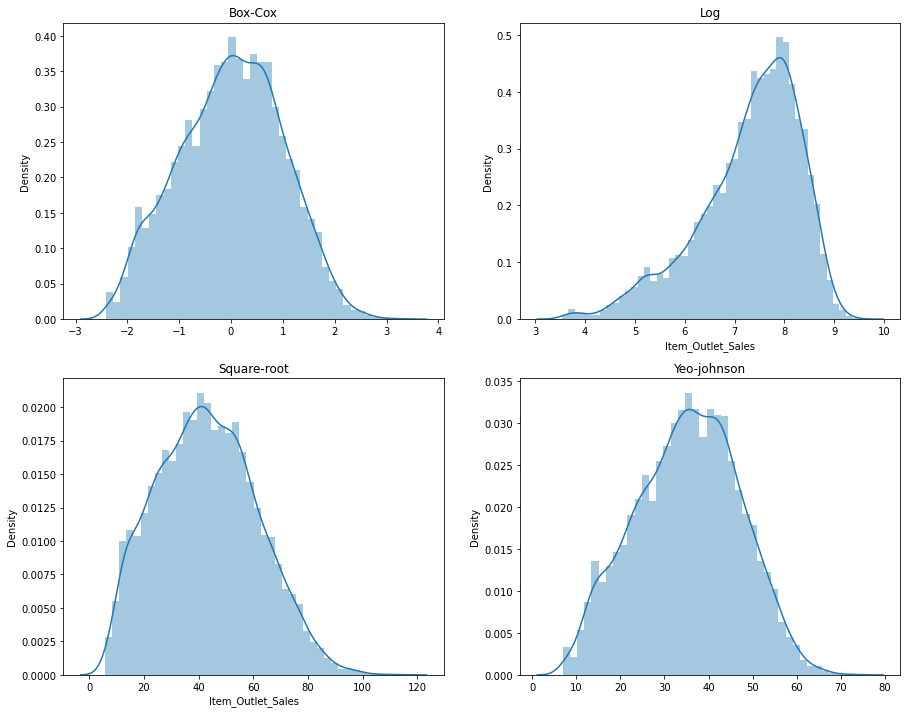

In [83]:
#Checking the plots for different transformations

plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
plt.title("Box-Cox")
pt = PowerTransformer(method='box-cox')
#Using pd.DataFrame as the input needs to be of the shape (n, 1) and not (n, )
sns.distplot(pt.fit_transform(pd.DataFrame(train_df['Item_Outlet_Sales'])))

plt.subplot(2, 2, 2)
plt.title("Log")
sns.distplot(np.log1p(train_df['Item_Outlet_Sales']))

plt.subplot(2, 2, 3)
plt.title("Square-root")
sns.distplot(train_df['Item_Outlet_Sales']**(1/2))

plt.subplot(2, 2, 4)
plt.title("Yeo-johnson")
yf_target, lam = yeojohnson(train_df['Item_Outlet_Sales'])
sns.distplot(yf_target)


plt.show()

Box-cox and yeo-johnson transformations appear to yield the best transformations. I'll use the box-cox transformation to modify the target variable.

In [84]:
#Transforming the target variable
train_df['Item_Outlet_Sales'] = pt.fit_transform(pd.DataFrame(train_df['Item_Outlet_Sales']))

In [85]:
train_df.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FD,9.300,Low Fat,0.017047,Dairy,249.8092,OUT049,11,Medium,Tier 1,Supermarket Type1,0.984978
1,DR,5.920,Regular,0.020278,Soft Drinks,48.2692,OUT018,1,Medium,Tier 3,Supermarket Type2,-1.217837
2,FD,17.500,Low Fat,0.017760,Meat,141.6180,OUT049,11,Medium,Tier 1,Supermarket Type1,0.220282
3,FD,19.200,Regular,0.001000,Fruits and Vegetables,182.0950,OUT010,12,Small,Tier 3,Grocery Store,-0.834969
4,NC,8.930,Low Fat,0.001000,Household,53.8614,OUT013,23,High,Tier 3,Supermarket Type1,-0.566490
5,FD,10.395,Regular,0.001000,Baking Goods,51.4008,OUT018,1,Medium,Tier 3,Supermarket Type2,-1.052591
6,FD,13.650,Regular,0.013741,Snack Foods,57.6588,OUT013,23,High,Tier 3,Supermarket Type1,-1.388458
7,FD,19.000,Low Fat,0.128470,Snack Foods,107.7622,OUT027,25,Medium,Tier 3,Supermarket Type3,1.094830
8,FD,16.200,Regular,0.017687,Frozen Foods,96.9726,OUT045,8,Small,Tier 2,Supermarket Type1,-0.492352
9,FD,19.200,Regular,0.095450,Frozen Foods,187.8214,OUT017,3,Small,Tier 2,Supermarket Type1,1.338156


Before encoding the data, I'll make a copy of the dataframes. This copy can be used for tree models.

In [86]:
train_df_tree = train_df.copy()
test_df_tree = test_df.copy()

### Encoding Categorical Data

In [87]:
#Creating an object of the OneHotEncoder class
enc = OneHotEncoder()

In [88]:
#Using OneHotEncoder for variables with four levels or fewer

onehotlabels = enc.fit_transform(train_df[['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 
                                           'Outlet_Location_Type', 'Outlet_Type']])


#Using the original column names to make the encoded columns easier to read

col_names = enc.get_feature_names(['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 
                                   'Outlet_Location_Type', 'Outlet_Type'])

In [89]:
#Converting the encoded columns into a dataframe

encoded_columns = pd.DataFrame(onehotlabels.toarray().astype(int), columns = col_names)
encoded_columns.columns

Index(['Item_Identifier_DR', 'Item_Identifier_FD', 'Item_Identifier_NC',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'],
      dtype='object')

In [90]:
#Dropping some columns since we only need n-1 columns to represent n levels

encoded_columns = encoded_columns.drop(['Item_Identifier_NC', 'Item_Fat_Content_Low Fat', 'Outlet_Size_High', 
                                       'Outlet_Location_Type_Tier 1', 'Outlet_Type_Supermarket Type2'], axis =1)

In [91]:
print("Shape of encoded columns:\n", encoded_columns.shape)
print("\n")
print("Shape of original train set: \n", train_df.shape)

Shape of encoded columns:
 (8523, 10)


Shape of original train set: 
 (8523, 12)


Merging these encoded columns with the original dataframe

In [92]:
train_df = pd.concat([train_df, encoded_columns], axis = 1)

In [93]:
#Dropping the columns that have been encoded
train_df = train_df.drop(['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 
                          'Outlet_Type'], axis = 1)

In [94]:
train_df.shape

(8523, 17)

#### Encoding the Outlet_Identifier column

In [95]:
#Checking the number of outlet identifiers
len(train_df['Outlet_Identifier'].unique())

10

I'll use feature hashing to encode this column, as there will be too many variables if I use one hot encoding.

In [96]:
#Instantiating the FeatureHasher class for the Outlet_Identifier column with number of output featuers = 4
fh_OI = FeatureHasher(n_features = 4, input_type='string')

#Transforming the column Outlet_Identifier
hashed_features_OI = fh_OI.fit_transform(train_df['Outlet_Identifier'])

In [97]:
#Converting the hash columns to an array
hashed_features_OI = hashed_features_OI.toarray()

#Concatenating the hash columns with the original dataframe
train_df = pd.concat([train_df, pd.DataFrame(hashed_features_OI)], axis = 1)

#Dropping the original column
train_df = train_df.drop(['Outlet_Identifier'], axis = 1)

In [98]:
train_df.head()

,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type3,0,1,2,3
0,9.30,0.017047,Dairy,249.8092,11,0.984978,0,1,0,1,0,0,0,0,1,0,-1.0,-1.0,0.0,0.0
1,5.92,0.020278,Soft Drinks,48.2692,1,-1.217837,1,0,1,1,0,0,1,0,0,0,0.0,-4.0,0.0,0.0
2,17.50,0.017760,Meat,141.6180,11,0.220282,0,1,0,1,0,0,0,0,1,0,-1.0,-1.0,0.0,0.0
3,19.20,0.001000,Fruits and Vegetables,182.0950,12,-0.834969,0,1,1,0,1,0,1,1,0,0,0.0,-4.0,0.0,0.0
4,8.93,0.001000,Household,53.8614,23,-0.566490,0,0,0,0,0,0,1,0,1,0,1.0,-3.0,0.0,0.0


I'll change the hashed column names to something more meaningful.

In [99]:
#Renaming the columns using a dictioanry
train_df.rename(columns = {0: 'Out_ID_H0', 1: 'Out_ID_H1', 2: 'Out_ID_H2', 3: 'Out_ID_H3'}, inplace=True)

#### Encoding the Item_Type column

In [100]:
#Checking the number of item types
len(train_df['Item_Type'].unique())

16

Using feature hasher again, as there are too many categories for one hot encoding.

In [101]:
#Instantiating the FeatureHasher class for the Outlet_Identifier column with number of output featuers = 4
fh_IT = FeatureHasher(n_features = 4, input_type='string')

#Transforming the Item_Type column
hashed_features_IT = fh_IT.fit_transform(train_df['Item_Type'])

In [102]:
#Converting the hash columns to an array
hashed_features_IT = hashed_features_IT.toarray()

#Concatenating the hash columns with the original dataframe
train_df = pd.concat([train_df, pd.DataFrame(hashed_features_IT)], axis = 1)

#Dropping the original column
train_df = train_df.drop(['Item_Type'], axis = 1)

In [103]:
train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,...,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type3,Out_ID_H0,Out_ID_H1,Out_ID_H2,Out_ID_H3,0,1,2,3
0,9.30,0.017047,249.8092,11,0.984978,0,1,0,1,0,...,1,0,-1.0,-1.0,0.0,0.0,0.0,0.0,3.0,0.0
1,5.92,0.020278,48.2692,1,-1.217837,1,0,1,1,0,...,0,0,0.0,-4.0,0.0,0.0,-1.0,0.0,1.0,-1.0
2,17.50,0.017760,141.6180,11,0.220282,0,1,0,1,0,...,1,0,-1.0,-1.0,0.0,0.0,0.0,0.0,2.0,0.0
3,19.20,0.001000,182.0950,12,-0.834969,0,1,1,0,1,...,0,0,0.0,-4.0,0.0,0.0,3.0,-1.0,0.0,1.0
4,8.93,0.001000,53.8614,23,-0.566490,0,0,0,0,0,...,1,0,1.0,-3.0,0.0,0.0,2.0,0.0,0.0,3.0


In [104]:
#Renaming the columns using a dictioanry
train_df.rename(columns = {0: 'IT_H0', 1: 'IT_H1', 2: 'IT_H2', 3: 'IT_H3'}, inplace=True)

#### Moving the target variable column to the end

In [105]:
#Getting a list of column names to rearrange them
cols = train_df.columns.tolist()
cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales',
 'Item_Identifier_DR',
 'Item_Identifier_FD',
 'Item_Fat_Content_Regular',
 'Outlet_Size_Medium',
 'Outlet_Size_Small',
 'Outlet_Location_Type_Tier 2',
 'Outlet_Location_Type_Tier 3',
 'Outlet_Type_Grocery Store',
 'Outlet_Type_Supermarket Type1',
 'Outlet_Type_Supermarket Type3',
 'Out_ID_H0',
 'Out_ID_H1',
 'Out_ID_H2',
 'Out_ID_H3',
 'IT_H0',
 'IT_H1',
 'IT_H2',
 'IT_H3']

In [106]:
#Putting target variable at the end
cols = cols[:4] + cols[5:] + [cols[4]]
train_df = train_df[cols]
train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,...,Outlet_Type_Supermarket Type3,Out_ID_H0,Out_ID_H1,Out_ID_H2,Out_ID_H3,IT_H0,IT_H1,IT_H2,IT_H3,Item_Outlet_Sales
0,9.30,0.017047,249.8092,11,0,1,0,1,0,0,...,0,-1.0,-1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.984978
1,5.92,0.020278,48.2692,1,1,0,1,1,0,0,...,0,0.0,-4.0,0.0,0.0,-1.0,0.0,1.0,-1.0,-1.217837
2,17.50,0.017760,141.6180,11,0,1,0,1,0,0,...,0,-1.0,-1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.220282
3,19.20,0.001000,182.0950,12,0,1,1,0,1,0,...,0,0.0,-4.0,0.0,0.0,3.0,-1.0,0.0,1.0,-0.834969
4,8.93,0.001000,53.8614,23,0,0,0,0,0,0,...,0,1.0,-3.0,0.0,0.0,2.0,0.0,0.0,3.0,-0.566490


### Encoding the test data

In [107]:
#Using OneHotEncoder for variables with four levels or fewer

onehotlabels_test = enc.transform(test_df[['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 
                                           'Outlet_Location_Type', 'Outlet_Type']])

In [108]:
#Converting the encoded columns into a dataframe and using the same col_names variable that was created for the train set

encoded_columns_test = pd.DataFrame(onehotlabels_test.toarray().astype(int), columns = col_names)
encoded_columns_test.columns

Index(['Item_Identifier_DR', 'Item_Identifier_FD', 'Item_Identifier_NC',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'],
      dtype='object')

In [109]:
#Dropping some columns since we only need n-1 columns to represent n levels

encoded_columns_test = encoded_columns_test.drop(['Item_Identifier_NC', 'Item_Fat_Content_Low Fat', 'Outlet_Size_High', 
                                       'Outlet_Location_Type_Tier 1', 'Outlet_Type_Supermarket Type2'], axis =1)

In [110]:
#Merging the encoded columns with the original dataframe

test_df = pd.concat([test_df, encoded_columns_test], axis = 1)

In [111]:
#Dropping the columns that have been encoded
test_df = test_df.drop(['Item_Identifier', 'Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type', 
                          'Outlet_Type'], axis = 1)

Encoding the Outlet_Identifier column

In [112]:
#Transforming the Outlet_Identifier column
hashed_features_OI_test = fh_OI.transform(test_df['Outlet_Identifier'])

In [113]:
#Converting the hash columns to an array
hashed_features_OI_test = hashed_features_OI_test.toarray()

#Concatenating the hash columns with the original dataframe
test_df = pd.concat([test_df, pd.DataFrame(hashed_features_OI_test)], axis = 1)

#Dropping the original column
test_df = test_df.drop(['Outlet_Identifier'], axis = 1)

In [114]:
test_df.head()

,Item_Weight,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type3,0,1,2,3
0,20.750,0.008565,Snack Foods,107.8622,11,0,1,0,1,0,0,0,0,1,0,-1.0,-1.0,0.0,0.0
1,8.300,0.039428,Dairy,87.3198,3,0,1,1,0,1,1,0,0,1,0,1.0,-3.0,0.0,0.0
2,14.600,0.100575,Others,241.7538,12,0,0,0,0,1,0,1,1,0,0,0.0,-4.0,0.0,0.0
3,7.315,0.016388,Snack Foods,155.0340,3,0,1,0,0,1,1,0,0,1,0,1.0,-3.0,0.0,0.0
4,13.600,0.119599,Dairy,234.2300,25,0,1,1,1,0,0,1,0,0,1,1.0,-2.0,0.0,1.0


In [115]:
#Renaming the columns using a dictioanry
test_df.rename(columns = {0: 'Out_ID_H0', 1: 'Out_ID_H1', 2: 'Out_ID_H2', 3: 'Out_ID_H3'}, inplace=True)

Encoding the Item_Type column

In [116]:
#Transforming the Item_Type column
hashed_features_IT_test = fh_IT.transform(test_df['Item_Type'])

In [117]:
#Converting the hash columns to an array
hashed_features_IT_test = hashed_features_IT_test.toarray()

#Concatenating the hash columns with the original dataframe
test_df = pd.concat([test_df, pd.DataFrame(hashed_features_IT_test)], axis = 1)

#Dropping the original column
test_df = test_df.drop(['Item_Type'], axis = 1)

In [118]:
#Renaming the columns using a dictioanry
test_df.rename(columns = {0: 'IT_H0', 1: 'IT_H1', 2: 'IT_H2', 3: 'IT_H3'}, inplace=True)

In [119]:
test_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,...,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type3,Out_ID_H0,Out_ID_H1,Out_ID_H2,Out_ID_H3,IT_H0,IT_H1,IT_H2,IT_H3
0,20.750,0.008565,107.8622,11,0,1,0,1,0,0,...,1,0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,0.0,1.0
1,8.300,0.039428,87.3198,3,0,1,1,0,1,1,...,1,0,1.0,-3.0,0.0,0.0,0.0,0.0,3.0,0.0
2,14.600,0.100575,241.7538,12,0,0,0,0,1,0,...,0,0,0.0,-4.0,0.0,0.0,0.0,0.0,1.0,-1.0
3,7.315,0.016388,155.0340,3,0,1,0,0,1,1,...,1,0,1.0,-3.0,0.0,0.0,-1.0,-1.0,0.0,1.0
4,13.600,0.119599,234.2300,25,0,1,1,1,0,0,...,0,1,1.0,-2.0,0.0,1.0,0.0,0.0,3.0,0.0


### Scaling the continuous variables

In [120]:
train_df[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']].describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.873623,0.067132,140.992782,12.168133
std,4.645893,0.051598,62.275067,8.371760
min,4.555000,0.001000,31.290000,1.000000
25%,8.785000,0.027989,93.826500,6.000000
50%,12.600000,0.054931,143.012800,11.000000
75%,16.850000,0.095585,185.643700,23.000000
max,21.350000,0.329391,266.888400,25.000000


In [121]:
#Creating a standard scaler object
scaler = StandardScaler()

In [122]:
#Making a list of columns that are to be scaled
var_for_scaling = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [123]:
#Scaling the columns
train_df[var_for_scaling] = scaler.fit_transform(train_df[var_for_scaling])

In [124]:
train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DR,Item_Identifier_FD,Item_Fat_Content_Regular,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,...,Outlet_Type_Supermarket Type3,Out_ID_H0,Out_ID_H1,Out_ID_H2,Out_ID_H3,IT_H0,IT_H1,IT_H2,IT_H3,Item_Outlet_Sales
0,-0.769246,-0.970732,1.747454,-0.139541,0,1,0,1,0,0,...,0,-1.0,-1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.984978
1,-1.496813,-0.908111,-1.489023,-1.334103,1,0,1,1,0,0,...,0,0.0,-4.0,0.0,0.0,-1.0,0.0,1.0,-1.0,-1.217837
2,0.995858,-0.956917,0.010040,-0.139541,0,1,0,1,0,0,...,0,-1.0,-1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.220282
3,1.361794,-1.281758,0.660050,-0.020085,0,1,1,0,1,0,...,0,0.0,-4.0,0.0,0.0,3.0,-1.0,0.0,1.0,-0.834969
4,-0.848890,-1.281758,-1.399220,1.293934,0,0,0,0,0,0,...,0,1.0,-3.0,0.0,0.0,2.0,0.0,0.0,3.0,-0.566490


### Splitting the data set

In [125]:
#Splitting the data 70-30

train_df, val_df = train_test_split(train_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [126]:
#Splitting into X_train and y_train (and X_val and y_val)

y_train = train_df.pop('Item_Outlet_Sales')
X_train = train_df

y_val = val_df.pop('Item_Outlet_Sales')
X_val = val_df

In [127]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(5966, 22)
(5966,)
(2557, 22)
(2557,)


In [128]:
#Splitting the data 70-30
train_df_tree, val_df_tree = train_test_split(train_df_tree, train_size = 0.7, test_size = 0.3, random_state = 100)


#Splitting into X_train_tree and y_train_tree (and X_val_tree and y_val_tree)

y_train_tree = train_df_tree.pop('Item_Outlet_Sales')
X_train_tree = train_df_tree

y_val_tree = val_df_tree.pop('Item_Outlet_Sales')
X_val_tree = val_df_tree

## Model Building

### 4. XGBoost using Hyperopt

In [136]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from xgboost import XGBRegressor

In [137]:
#Initializing a required range or space

space = {'max_depth': hp.quniform('max_depth', 4, 16, 2),
         'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
         'n_estimators': hp.quniform('n_estimators', 50, 200, 25),
         'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 0.9, 0.1),
         'reg_alpha': hp.uniform('reg_alpha', 0, 0.1),
         'reg_lambda': hp.uniform('reg_lambda', 0, 0.1),
         'gamma': hp.quniform('gamma', 0, 0.5, 0.1)
}

In [138]:
def hyperparameter_tuning(space):
    model = XGBRegressor(max_depth = int(space['max_depth']), min_child_weight = int(space['min_child_weight']), 
                         n_estimators = int(space['n_estimators']), reg_alpha = int(space['reg_alpha']), 
                          reg_lambda = int(space['reg_lambda']), gamma = int(space['gamma']))
    
    evaluation = [(X_train, y_train), (X_val, y_val)]
    
    model.fit(X_train, y_train, eval_set = evaluation, eval_metric = "rmse", verbose = True)
    
    pred = model.predict(X_val)
    r2_score_val = r2_score(y_val, pred)
    print("Validation R-squared: ", r2_score_val)
    
    rmse_score = np.sqrt(mean_squared_error(y_val, pred))
    
    return {'loss': rmse_score, 'status': STATUS_OK, 'model': model}

In [139]:
trials = Trials()

best = fmin(fn = hyperparameter_tuning, space = space, algo = tpe.suggest, max_evals = 10, trials = trials)

print(best)

[0]	validation_0-rmse:0.85891	validation_1-rmse:0.86841                                                                

[1]	validation_0-rmse:0.68398	validation_1-rmse:0.72990                                                                

[2]	validation_0-rmse:0.57283	validation_1-rmse:0.65364                                                                

[3]	validation_0-rmse:0.50406	validation_1-rmse:0.61207                                                                

[4]	validation_0-rmse:0.46075	validation_1-rmse:0.59367                                                                

[5]	validation_0-rmse:0.43364	validation_1-rmse:0.58649                                                                

[6]	validation_0-rmse:0.41751	validation_1-rmse:0.58421                                                                

[7]	validation_0-rmse:0.40042	validation_1-rmse:0.58338                                                                

[8]	validation_0-rmse:0.38644	va

[5]	validation_0-rmse:0.38250	validation_1-rmse:0.59473                                                                

[6]	validation_0-rmse:0.36241	validation_1-rmse:0.59335                                                                

[7]	validation_0-rmse:0.34338	validation_1-rmse:0.59343                                                                

[8]	validation_0-rmse:0.32737	validation_1-rmse:0.59625                                                                

[9]	validation_0-rmse:0.31905	validation_1-rmse:0.59797                                                                

[10]	validation_0-rmse:0.31233	validation_1-rmse:0.59923                                                               

[11]	validation_0-rmse:0.30576	validation_1-rmse:0.60109                                                               

[12]	validation_0-rmse:0.29335	validation_1-rmse:0.60194                                                               

[13]	validation_0-rmse:0.28178	v

[139]	validation_0-rmse:0.04904	validation_1-rmse:0.62953                                                              

[140]	validation_0-rmse:0.04773	validation_1-rmse:0.62973                                                              

[141]	validation_0-rmse:0.04739	validation_1-rmse:0.62971                                                              

[142]	validation_0-rmse:0.04695	validation_1-rmse:0.62973                                                              

[143]	validation_0-rmse:0.04679	validation_1-rmse:0.62973                                                              

[144]	validation_0-rmse:0.04665	validation_1-rmse:0.62976                                                              

[145]	validation_0-rmse:0.04613	validation_1-rmse:0.62976                                                              

[146]	validation_0-rmse:0.04568	validation_1-rmse:0.62980                                                              

[147]	validation_0-rmse:0.04545	

[121]	validation_0-rmse:0.08686	validation_1-rmse:0.63878                                                              

[122]	validation_0-rmse:0.08404	validation_1-rmse:0.63930                                                              

[123]	validation_0-rmse:0.08324	validation_1-rmse:0.63924                                                              

[124]	validation_0-rmse:0.08237	validation_1-rmse:0.63947                                                              

Validation R-squared:                                                                                                  
0.5792693243988098                                                                                                     
[0]	validation_0-rmse:0.87096	validation_1-rmse:0.86624                                                                

[1]	validation_0-rmse:0.71119	validation_1-rmse:0.72505                                                                

[2]	validation_0-rmse:0.61484	vali

[76]	validation_0-rmse:0.03142	validation_1-rmse:0.63881                                                               

[77]	validation_0-rmse:0.03120	validation_1-rmse:0.63883                                                               

[78]	validation_0-rmse:0.03011	validation_1-rmse:0.63886                                                               

[79]	validation_0-rmse:0.03004	validation_1-rmse:0.63889                                                               

[80]	validation_0-rmse:0.02940	validation_1-rmse:0.63889                                                               

[81]	validation_0-rmse:0.02790	validation_1-rmse:0.63917                                                               

[82]	validation_0-rmse:0.02733	validation_1-rmse:0.63929                                                               

[83]	validation_0-rmse:0.02655	validation_1-rmse:0.63932                                                               

[84]	validation_0-rmse:0.02637	v

[58]	validation_0-rmse:0.26324	validation_1-rmse:0.60651                                                               

[59]	validation_0-rmse:0.26153	validation_1-rmse:0.60728                                                               

[60]	validation_0-rmse:0.25975	validation_1-rmse:0.60742                                                               

[61]	validation_0-rmse:0.25683	validation_1-rmse:0.60810                                                               

[62]	validation_0-rmse:0.25511	validation_1-rmse:0.60872                                                               

[63]	validation_0-rmse:0.25344	validation_1-rmse:0.60905                                                               

[64]	validation_0-rmse:0.25188	validation_1-rmse:0.60984                                                               

[65]	validation_0-rmse:0.24683	validation_1-rmse:0.61031                                                               

[66]	validation_0-rmse:0.24539	v

[90]	validation_0-rmse:0.02354	validation_1-rmse:0.63943                                                               

[91]	validation_0-rmse:0.02283	validation_1-rmse:0.63947                                                               

[92]	validation_0-rmse:0.02242	validation_1-rmse:0.63948                                                               

[93]	validation_0-rmse:0.02225	validation_1-rmse:0.63946                                                               

[94]	validation_0-rmse:0.02184	validation_1-rmse:0.63949                                                               

[95]	validation_0-rmse:0.02144	validation_1-rmse:0.63949                                                               

[96]	validation_0-rmse:0.02114	validation_1-rmse:0.63949                                                               

[97]	validation_0-rmse:0.02102	validation_1-rmse:0.63948                                                               

[98]	validation_0-rmse:0.02077	v

[72]	validation_0-rmse:0.12226	validation_1-rmse:0.63144                                                               

[73]	validation_0-rmse:0.12053	validation_1-rmse:0.63183                                                               

[74]	validation_0-rmse:0.11954	validation_1-rmse:0.63222                                                               

[75]	validation_0-rmse:0.11719	validation_1-rmse:0.63263                                                               

[76]	validation_0-rmse:0.11586	validation_1-rmse:0.63285                                                               

[77]	validation_0-rmse:0.11376	validation_1-rmse:0.63344                                                               

[78]	validation_0-rmse:0.11283	validation_1-rmse:0.63360                                                               

[79]	validation_0-rmse:0.11232	validation_1-rmse:0.63365                                                               

[80]	validation_0-rmse:0.10758	v

In [140]:
xgb_model = XGBRegressor(colsample_bytree = 0.7, gamma = 0.1, max_depth = 8, min_child_weight = 7, n_estimators = 50,
                         reg_alpha = 0.06586, reg_lambda = 0.01247)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=7, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0.06586, reg_lambda=0.01247, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [141]:
#Checking the R-squared value

train_predictions = xgb_model.predict(X_train)
#train_predictions = (np.array(train_predictions)).reshape(-1, 1)

val_predictions = xgb_model.predict(X_val)
#val_predictions = (np.array(val_predictions)).reshape(-1, 1)

print(train_predictions.shape)
print(val_predictions.shape)

(5966,)
(2557,)


In [143]:
print("Train set R-squared value: {:.4f}" .format(r2_score(y_train, train_predictions)))
print("Validation set R-squared value: {:.4f}" .format(r2_score(y_val, val_predictions)))

Train set R-squared value: 0.8807
Validation set R-squared value: 0.6360
